## Seattle Airbnb

### 1. Business Understanding
 Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA. [(source)](https://www.kaggle.com/airbnb/seattle/home)

The following Airbnb activity is included in this Seattle [dataset](https://www.kaggle.com/airbnb/seattle/data):
* Listings, including full descriptions and average review score 
* Reviews, including unique id for each reviewer and detailed comments
* Calendar, including listing id and the price and availability for that day

Questions we try to analyze in this report are as follows:<br>
* **Q1: When is the best time of the year to visit Seattle in terms of availability and pricing?**<br>
* **Q2: Do prices and availability change depending the weekday?**<br>
* **Q3: Where are the best locations to book a place through Airbnb?**<br>
* **Q4: Can we use listing information to predict the housing price?**<br>
* **Q5: Which variables impact the most to price?**<br>

### 2. Data Understanding and Preparation

Necessary libraries are imported. To answer the previous business questions, listings and calendar datasets will be used for the analysis

In [1]:
# libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
%matplotlib inline

# data load
listings_df = pd.read_csv('airbnbseattle_data/listings.csv')
calendar_df = pd.read_csv('airbnbseattle_data/calendar.csv')

#### 2.1 Calendar df

In [2]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
# Calendar dataset size
print('The number of rows in calendar dataset is:', calendar_df.shape[0])
print('The number of variables in calendar dataset is:', calendar_df.shape[1])

The number of rows in calendar dataset is: 1393570
The number of variables in calendar dataset is: 4


In [4]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


- **Price** variable: data cleaning and price distribution

In [5]:
#It seems there are NaN values on price variable
np.sum(calendar_df.isnull())

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [6]:
#Clean price variable (price), cleaning $ characters
calendar_df['price'] = calendar_df['price'].str.extract('([0-9]+\.[0-9]+)').astype(float)  

In [7]:
calendar_df.describe()

,listing_id,price
count,1.393570e+06,934542.000000
mean,5.550111e+06,137.199039
std,2.962274e+06,101.387024
min,3.335000e+03,0.000000
25%,3.258213e+06,75.000000
50%,6.118244e+06,109.000000
75%,8.035212e+06,160.000000
max,1.034016e+07,999.000000


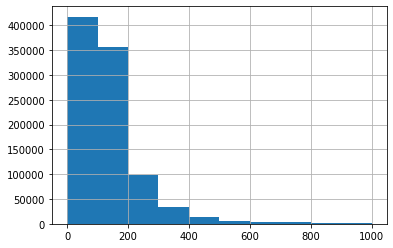

In [8]:
calendar_df['price'].hist()

- **date** variable: data cleaning and definition of new date variables

In [9]:
# date variable to datetime
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
# extracting year,month and weekday from date variable
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['weekday'] = calendar_df['date'].dt.weekday

In [10]:
# translating weedkays and months making them categorical to sort them

calendar_df['weekday_cat'] = calendar_df['weekday'].map({0: 'Mon', 1 : 'Tue', 
                                                             2 : 'Wed', 3 : 'Thu', 
                                                             4 : 'Fri', 5 : 'Sat' , 6 : 'Sun'})

calendar_df['month_cat'] = calendar_df['month'].map({1: 'Jan', 2 : 'Feb', 3: 'Mar', 
                                                     4: 'Apr', 5 : 'May',  6 : 'Jun',
                                                     7 : 'Jul', 8 : 'Aug' , 9 : 'Sep',
                                                     10 : 'Oct', 11 : 'Nov' , 12 : 'Dec'})

calendar_df['weekday_cat'] = pd.Categorical(calendar_df['weekday_cat'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
calendar_df['month_cat'] = pd.Categorical(calendar_df['month_cat'], categories = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], ordered=True)

- **available** variable: definition of occupation variable

In [11]:
## mapping 't' to 0 and 'f' to 1 in the available variable to define occupation variable
calendar_df['occupied'] = calendar_df['available'].map({'t': 0, 'f' : 1 })

With calendar_df prepared, we are able to answer the following questions:<br><br>
**Q1: When is the best time of the year to visit Seattle in terms of availability and pricing?** <br>
**Q2: Do prices and availability change depending the weekday?**<br>

Let's go!

#### Occupancy rate and average price

Let's find out occupancy rates and average prices in terms of seasonality

- Occupancy rates

Text(0.5, 0, 'Year Month')

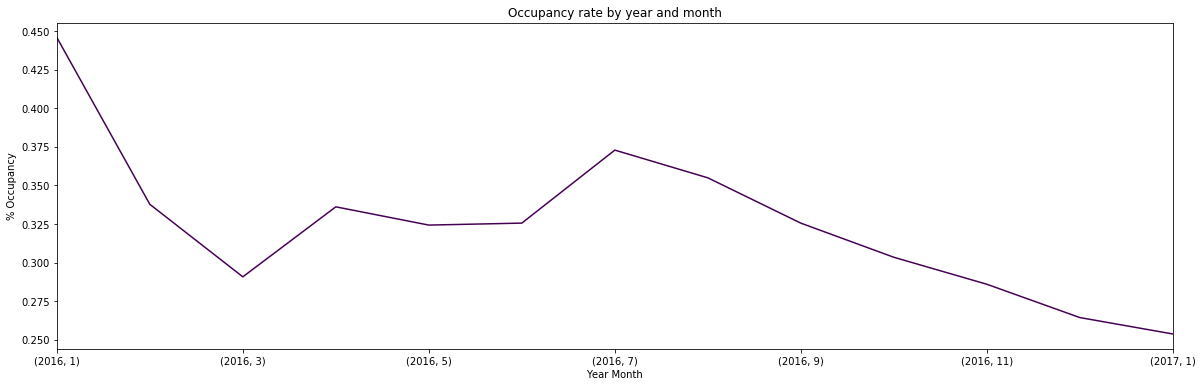

In [12]:
#Occupation rate by month 
plt.figure(figsize = (14,6))
calendar_df.groupby(['year','month'])['occupied'].mean().plot(cmap="viridis", figsize=(20, 6))
plt.title('Occupancy rate by year and month')
plt.ylabel('% Occupancy', size=10)
plt.xlabel('Year Month', size=10)

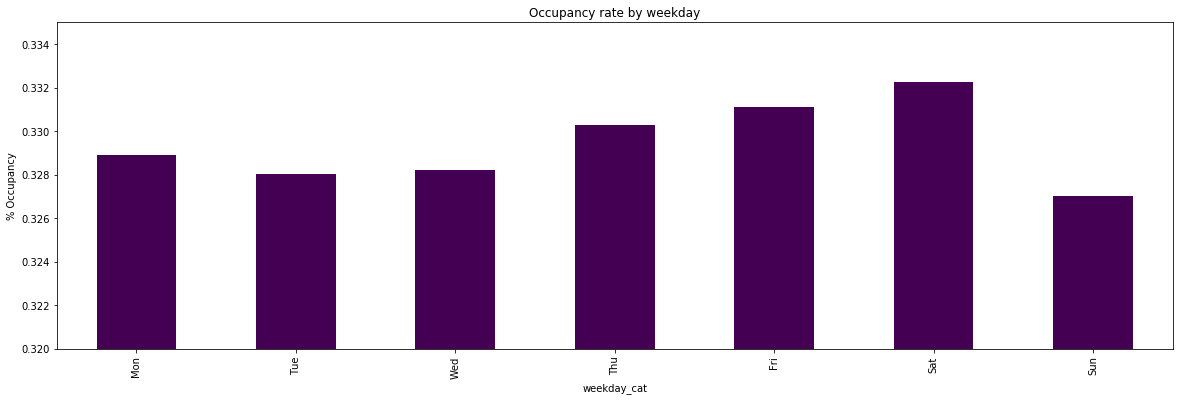

In [13]:
#Occupation rate by weekday 
plt.figure(figsize = (14,6))
axes = plt.gca()
axes.set_ylim([0.32,0.335])
plt.title('Occupancy rate by weekday')
plt.ylabel('% Occupancy', size=10)
plt.xlabel('Day of the week', size=10)
calendar_df.groupby(['weekday_cat'])['occupied'].mean().plot(kind='bar',cmap="viridis", figsize=(20, 6))

From the visualizations above, we conclude:

- Seasonality: Occupation increases on summer dates, decreases on autumn. I find a bit confusing jan 2016 occupancy data, where occupation meets its higher level in the whole dataset. More years data would be needed to check the seasonality. 
- Occupation increases on weekends

Let's represent on a heatmap occupancy vs month and weekday:

In [14]:
day_month_oc_df = pd.DataFrame(calendar_df.groupby(['month_cat', 'weekday_cat']).mean()['occupied'])
day_month_oc_df = day_month_oc_df.reset_index()
day_month_oc_df = day_month_oc_df.pivot('month_cat','weekday_cat','occupied')

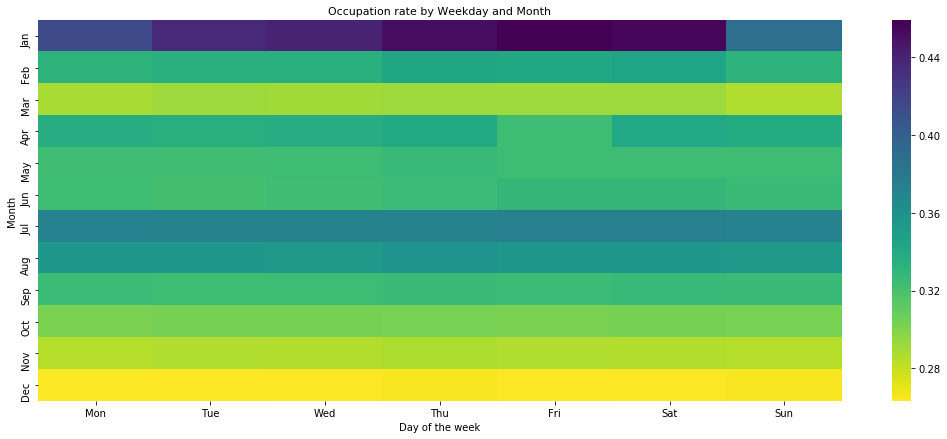

In [15]:
plt.figure(figsize=(18,7))
sns.heatmap(day_month_oc_df, cmap = 'viridis_r')
plt.title('Occupation rate by Weekday and Month', size=11)
plt.ylabel('Month', size=10)
plt.xlabel('Day of the week', size=10)
plt.show()

We see that occupation increases on weekends across the year

In [16]:
pd.DataFrame(calendar_df.groupby(['weekday_cat']).mean()['occupied']).reset_index()

,weekday_cat,occupied
0,Mon,0.328899
1,Tue,0.328046
2,Wed,0.328207
3,Thu,0.330257
4,Fri,0.331089
5,Sat,0.332242
6,Sun,0.326999


In [17]:
pd.DataFrame(calendar_df.groupby(['month_cat']).mean()['occupied']).reset_index()

,month_cat,occupied
0,Jan,0.433063
1,Feb,0.337792
2,Mar,0.290813
3,Apr,0.336153
4,May,0.324330
5,Jun,0.325616
6,Jul,0.372903
7,Aug,0.354949
8,Sep,0.325598
9,Oct,0.303486


- Average price

Text(0.5, 0, 'Year Month')

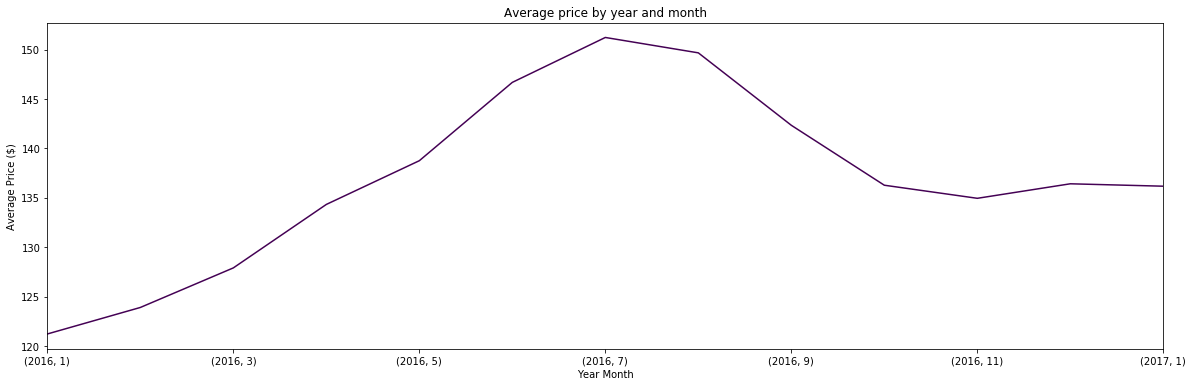

In [18]:
#Average price by month 
plt.figure(figsize = (14,6))
calendar_df.groupby(['year','month'])['price'].mean().plot(cmap="viridis", figsize=(20, 6))
plt.title('Average price by year and month', size=12)
plt.ylabel('Average Price ($)', size=10)
plt.xlabel('Year Month', size=10)

Text(0.5, 0, 'Weekday')

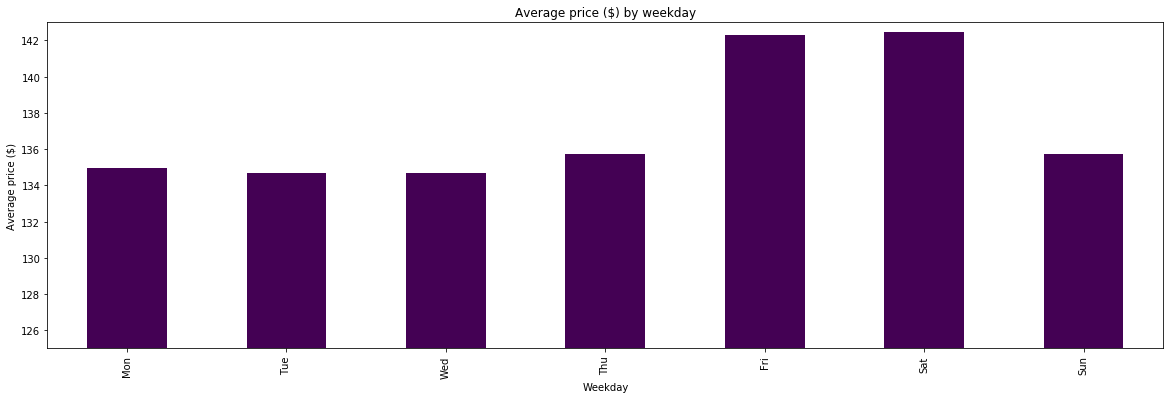

In [19]:
#Average price by weekday 
plt.figure(figsize = (14,6))
axes = plt.gca()
axes.set_ylim([125,143])
calendar_df.groupby(['weekday_cat'])['price'].mean().plot(kind='bar',cmap="viridis", figsize=(20, 6))
plt.title('Average price ($) by weekday', size=12)
plt.ylabel('Average price ($)', size=10)
plt.xlabel('Weekday', size=10)

From the visualizations above, we conclude:

- Seasonality: Avg Price increases on summer dates and decreases on autumn; but keeps higher than early dates of the year. 
- Average price increases on weekends

Let's represent on a heatmap avg price vs month and weekday:

In [20]:
day_month_price_df = pd.DataFrame(calendar_df.groupby(['month_cat', 'weekday_cat']).mean()['price'])
day_month_price_df = day_month_price_df.reset_index()
day_month_price_df = day_month_price_df.pivot('month_cat','weekday_cat','price')

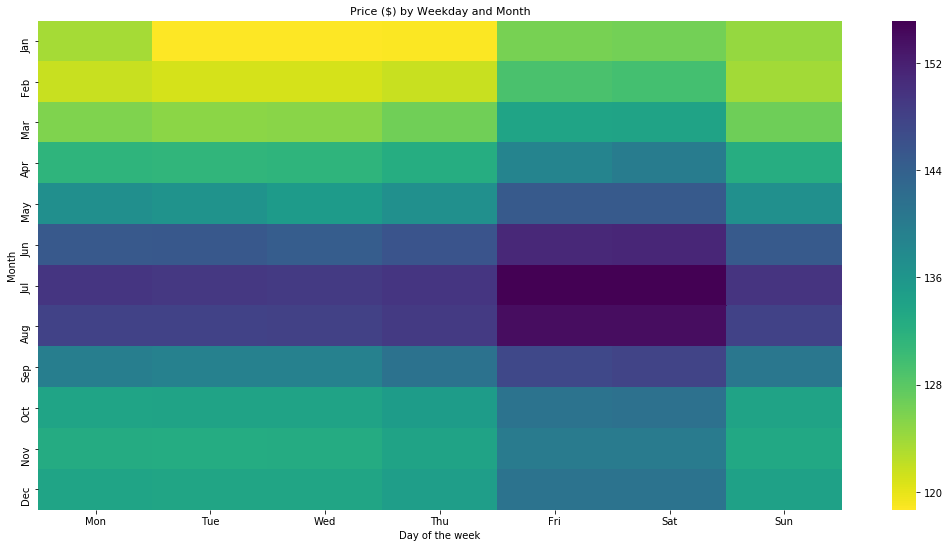

In [21]:
plt.figure(figsize=(18,9))
sns.heatmap(day_month_price_df, cmap = 'viridis_r')
plt.title('Price ($) by Weekday and Month', size=11)
plt.ylabel('Month', size=10)
plt.xlabel('Day of the week', size=10)
plt.show()

We see clearly that averages prices increseases for friday and saturday reservations, being July the most expensive month 

In [22]:
pd.DataFrame(calendar_df.groupby(['weekday_cat']).mean()['price']).reset_index()

,weekday_cat,price
0,Mon,134.940037
1,Tue,134.666674
2,Wed,134.705612
3,Thu,135.723971
4,Fri,142.283299
5,Sat,142.440297
6,Sun,135.726490


In [23]:
pd.DataFrame(calendar_df.groupby(['month_cat']).mean()['occupied']).reset_index()

,month_cat,occupied
0,Jan,0.433063
1,Feb,0.337792
2,Mar,0.290813
3,Apr,0.336153
4,May,0.324330
5,Jun,0.325616
6,Jul,0.372903
7,Aug,0.354949
8,Sep,0.325598
9,Oct,0.303486


- Occupation, price by month and weekday <br>
Let's go further and combine numeric variables with date variables

In [24]:
month_price_oc_df = pd.DataFrame(calendar_df.groupby(['month_cat']).mean()[['occupied','price']]).reset_index()
weekday_price_oc_df = pd.DataFrame(calendar_df.groupby(['weekday_cat']).mean()[['occupied','price']]).reset_index()

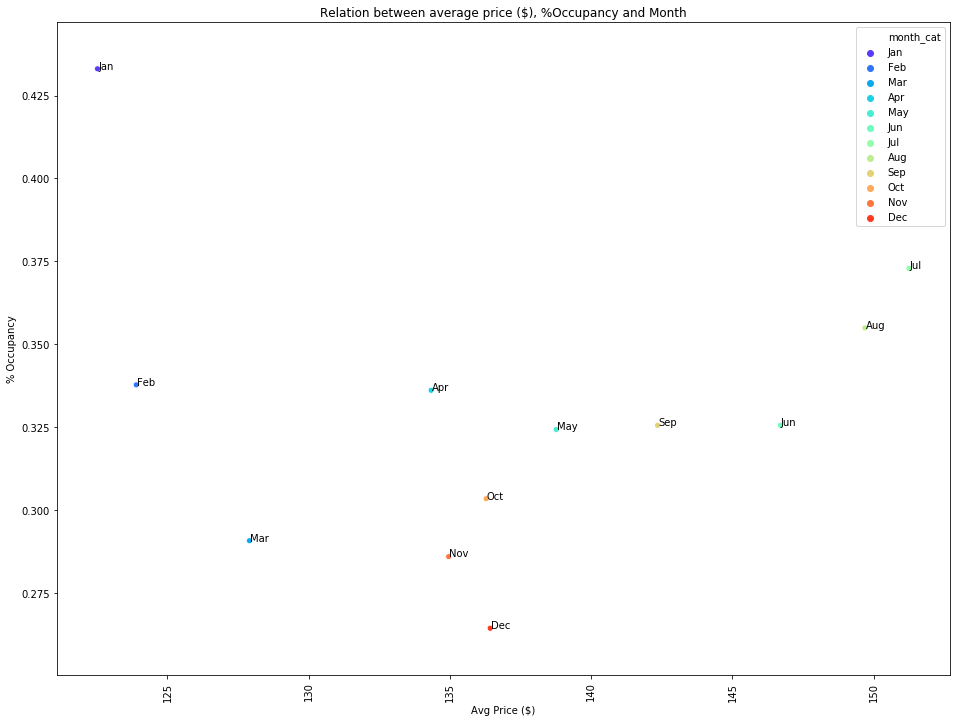

In [25]:
#Price and occupation by month
plt.figure(figsize=(16,12))
plt.xticks(rotation=90)
sns.scatterplot(x='price',y='occupied',hue='month_cat',palette='rainbow',data=month_price_oc_df)
plt.title('Relation between average price ($), %Occupancy and Month', size=12)
plt.ylabel('% Occupancy', size=10)
plt.xlabel('Avg Price ($)', size=10)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(month_price_oc_df.price, month_price_oc_df.occupied, month_price_oc_df.month_cat, plt.gca()) 

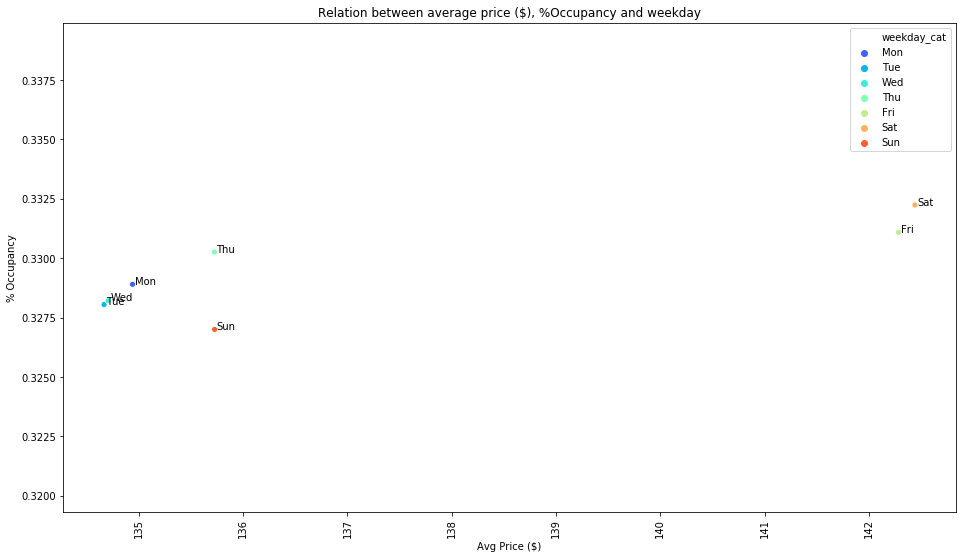

In [26]:
#Price and occupation by weekday
plt.figure(figsize=(16,9))
plt.xticks(rotation=90)
sns.scatterplot(x='price',y='occupied',hue='weekday_cat',palette='rainbow',data=weekday_price_oc_df)
plt.title('Relation between average price ($), %Occupancy and weekday', size=12)
plt.ylabel('% Occupancy', size=10)
plt.xlabel('Avg Price ($)', size=10)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(weekday_price_oc_df.price, weekday_price_oc_df.occupied, weekday_price_oc_df.weekday_cat, plt.gca()) 

- If you are planning for a cheap booking January and February are your months. But keep in mind that the reservation rate is higher than other months except for summer dates (July and Aug)
- Booking a place on weekends will be more expensive than labour days, taking also into account that there will also more demand

#### 2.2 Listings df

In [27]:
pd.set_option('display.max_columns',400)
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [28]:
# listings dataset size
print('The number of rows in this dataset is:',listings_df.shape[0])
print('The number of variables in this dataset is:',listings_df.shape[1])

The number of rows in this dataset is: 3818
The number of variables in this dataset is: 92


In [29]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [30]:
#Clean currency variables 
currency = ['price', 'monthly_price', 'weekly_price', 'security_deposit', 'cleaning_fee']
for col in currency:
    listings_df[col] = listings_df[[col]].replace('[\$,)]','',regex=True).astype(float)   


In [31]:
listings_df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,2009.000000,1517.000000,1866.000000,2788.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,127.976166,788.481832,2613.336190,287.610397,61.710904,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,90.250022,532.352269,1722.267981,270.222690,48.830341,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,100.000000,500.000000,95.000000,5.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,75.000000,455.000000,1512.000000,150.000000,25.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,100.000000,650.000000,2200.000000,250.000000,50.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,150.000000,950.000000,3150.000000,300.000000,83.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,1000.000000,6300.000000,19500.000000,5000.000000,300.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


With listings_df prepared, we are able to answer:<br><br>
**Q3: Where are the best locations to book a place through Airbnb?** <br>

Let's do this!

I've based my experience on booking hotel rooms through webs like booking.com or trivago.es to answer this question. I always try to book a room with a good price and an excellent review. It's a good rule in order to don't spend much time in this proccess. Usually, higher prices are strongly related with the best reviews. I've asummed this hypotesis and apply in on different Seattle neighbourhoods, abstracting myself from the rest of variables, which will be seen later on model section.

Let's start with some EDA.

- Price

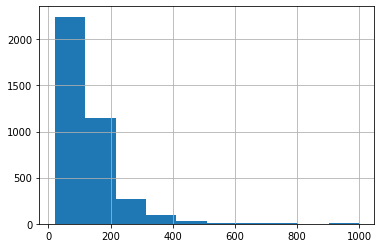

In [32]:
# Price distribution
listings_df['price'].hist()

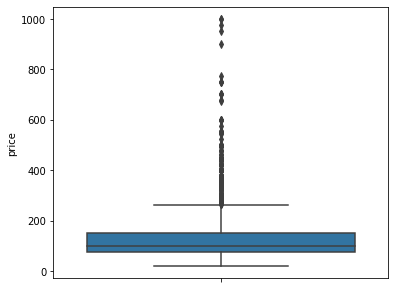

In [33]:
# Price distribution boxplot 
fig = plt.figure(figsize=(6,5))
plt.ylabel('Price')
sns.boxplot(y='price', data=listings_df)

In [34]:
listings_df['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

- Review Scores

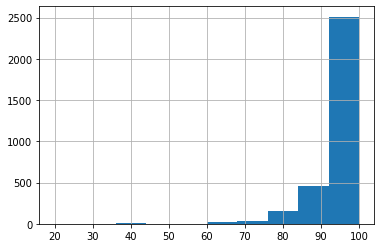

In [35]:
# Review score rating distribution
listings_df['review_scores_rating'].hist()

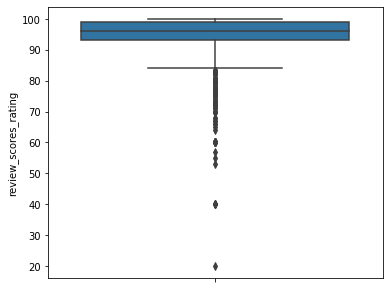

In [36]:
# Review score distribution boxplot 
fig = plt.figure(figsize=(6,5))
plt.ylabel('Price')
sns.boxplot(y='review_scores_rating', data=listings_df)

In [37]:
listings_df['review_scores_rating'].describe()

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

- Places locations in Seattle

In [38]:
map = folium.Map(location=[47.60, -122.24], zoom_start = 11)

data = [[row['latitude'],row['longitude']] for index, row in
             listings_df[['latitude', 'longitude']].iterrows()]

heatmap =  HeatMap(data).add_to(map)

map

- Price locations in Seattle

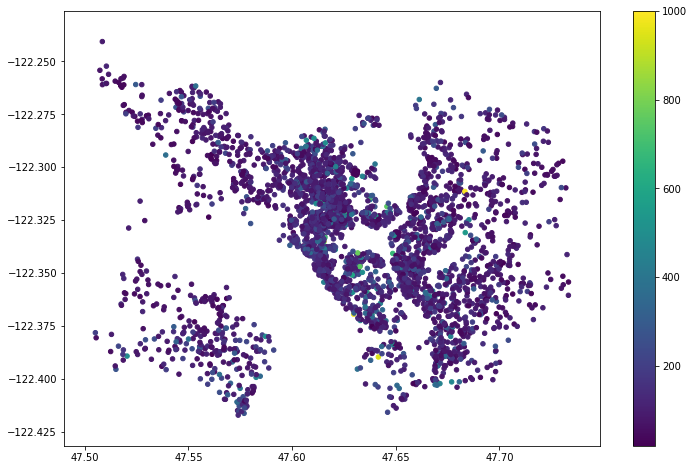

In [39]:
plt.figure(figsize=(12,8))
points = plt.scatter(listings_df['latitude'], listings_df['longitude'], c=listings_df["price"], s=20, cmap="viridis") 
plt.colorbar(points)

We don't see areas significantly cheap or expensive 

- n places by neighbourhood

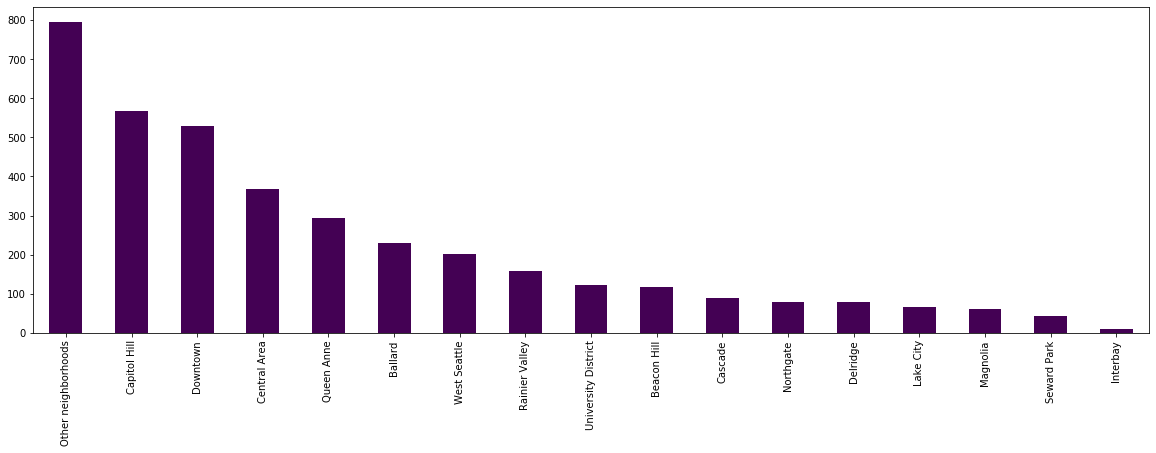

In [40]:
listings_df['neighbourhood_group_cleansed'].value_counts().head(100).plot(kind='bar',cmap="viridis", figsize=(20, 6))

In [41]:
listings_df['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

- avg price by neighbourhood

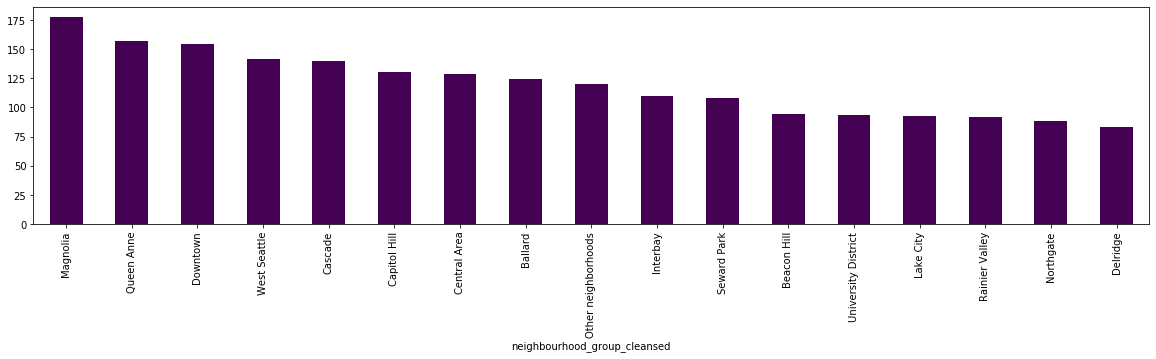

In [42]:
listings_df['price'].groupby(listings_df['neighbourhood_group_cleansed']).mean().sort_values(ascending = False).head(100).plot(kind='bar',cmap="viridis", figsize=(20, 4))

In [43]:
listings_df['price'].groupby(listings_df['neighbourhood_group_cleansed']).mean().sort_values(ascending = False)

neighbourhood_group_cleansed
Magnolia               177.672131
Queen Anne             157.223729
Downtown               154.405660
West Seattle           141.359606
Cascade                140.101124
Capitol Hill           130.592593
Central Area           128.338753
Ballard                124.682609
Other neighborhoods    119.968514
Interbay               109.727273
Seward Park            108.477273
Beacon Hill             94.669492
University District     93.639344
Lake City               92.671642
Rainier Valley          91.899371
Northgate               88.550000
Delridge                83.278481
Name: price, dtype: float64

- Price distribution by neighbourhood

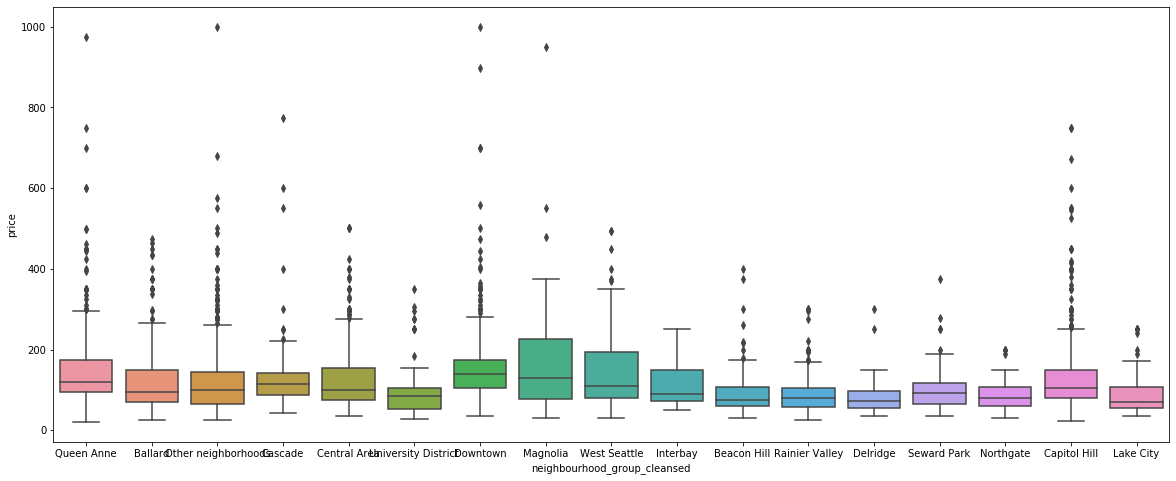

In [44]:
# Let's see the price distribution through different neigbourhoods
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.ylabel('Price')
sns.boxplot(y='price', x='neighbourhood_group_cleansed', data=listings_df)

Median price is similar but the range differs widely

In [45]:
price_range = [400, 500, 550, 600, 650, 700, 800, 900]

for i in price_range:
    print("There are", listings_df[listings_df.price > i].shape[0], "prices greater than", i)

There are 63 prices greater than 400
There are 27 prices greater than 500
There are 20 prices greater than 550
There are 14 prices greater than 600
There are 14 prices greater than 650
There are 9 prices greater than 700
There are 5 prices greater than 800
There are 4 prices greater than 900


- Avg rating by neighbourhood

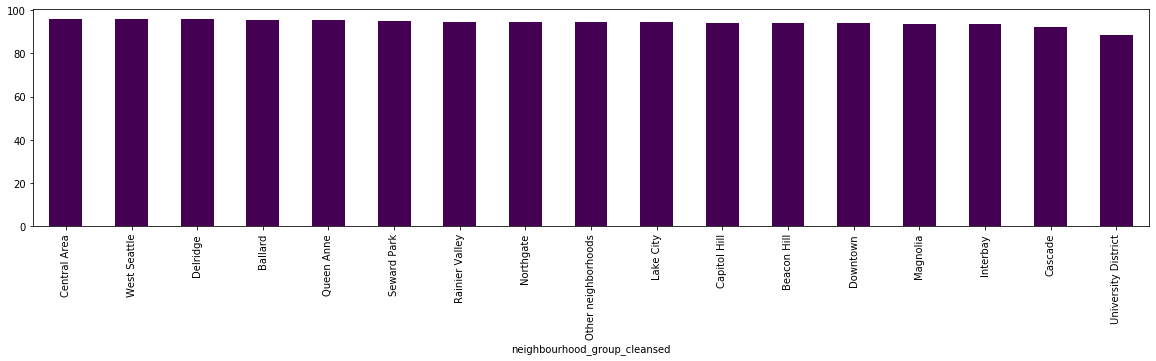

In [46]:
listings_df['review_scores_rating'].groupby(listings_df['neighbourhood_group_cleansed']).mean().sort_values(ascending = False).head(100).plot(kind='bar',cmap="viridis", figsize=(20, 4))

In [47]:
listings_df['review_scores_rating'].groupby(listings_df['neighbourhood_group_cleansed']).mean().sort_values(ascending = False)

neighbourhood_group_cleansed
Central Area           96.009404
West Seattle           95.864198
Delridge               95.861538
Ballard                95.533679
Queen Anne             95.443089
Seward Park            95.025641
Rainier Valley         94.731343
Northgate              94.692308
Other neighborhoods    94.562500
Lake City              94.375000
Capitol Hill           94.184783
Beacon Hill            94.019417
Downtown               93.958333
Magnolia               93.787234
Interbay               93.777778
Cascade                92.461538
University District    88.437500
Name: review_scores_rating, dtype: float64

- Avg rating distribution by neighbourhood

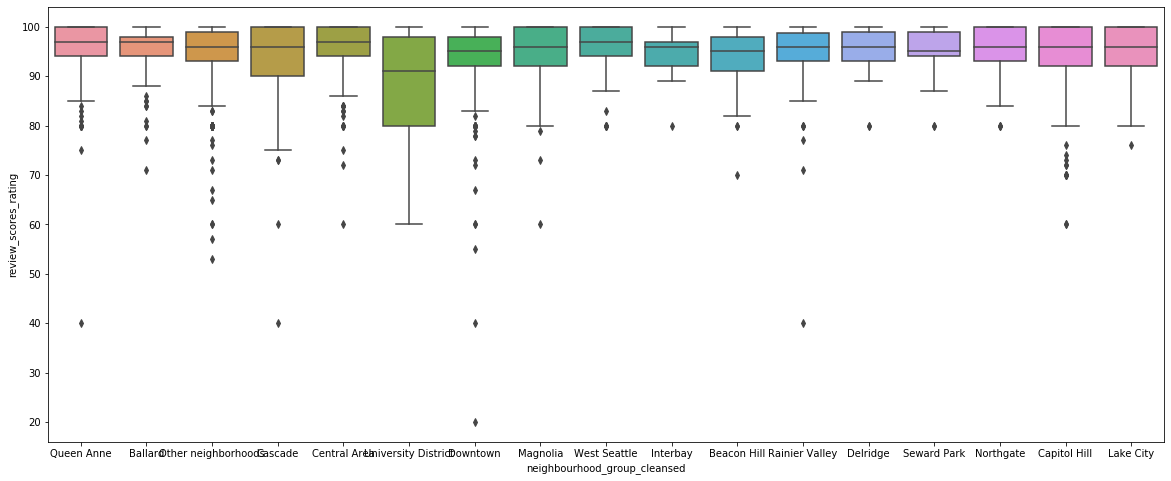

In [48]:
# Let's see the price distribution through different neigbourhoods
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.ylabel('Review scores')
sns.boxplot(y='review_scores_rating', x='neighbourhood_group_cleansed', data=listings_df)

Let's go further and search for relation between through variables

- Rating and price by neighbourhood

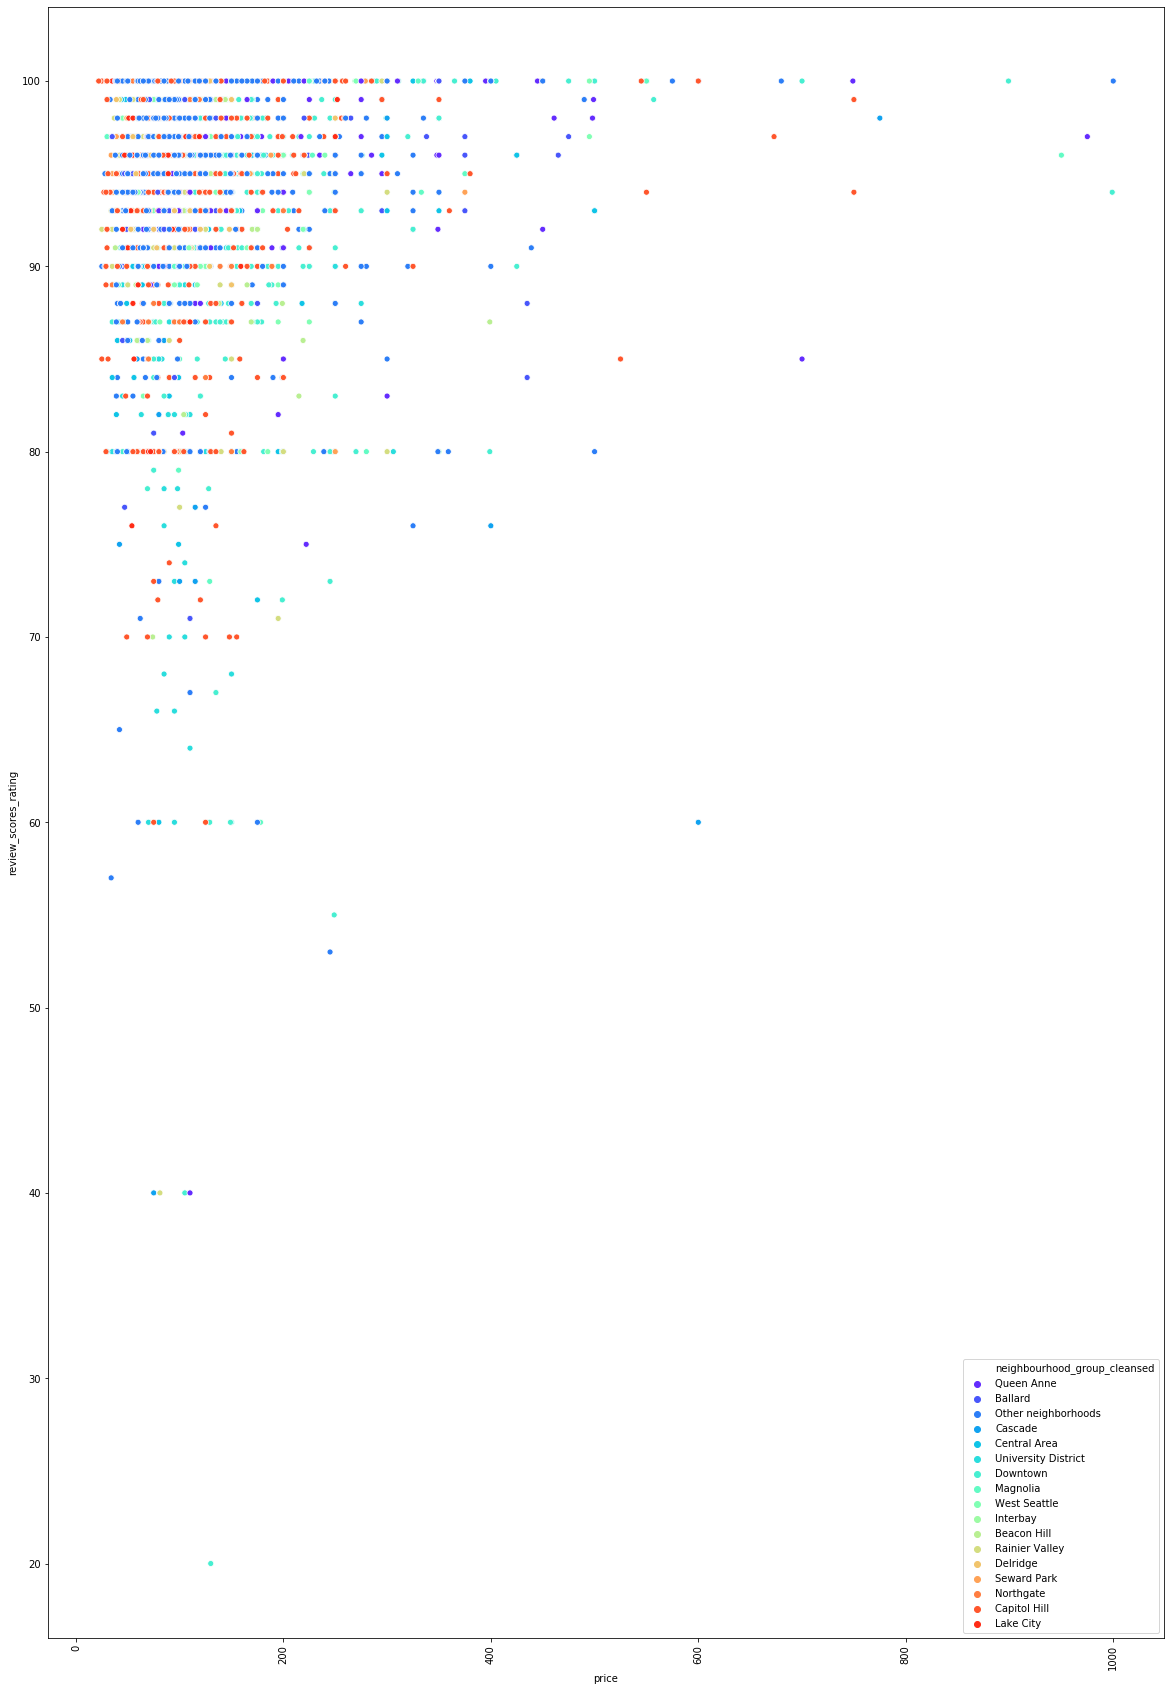

In [49]:
#Price and location distribution
plt.figure(figsize=(20,30))
plt.xticks(rotation=90)
sns.scatterplot(x='price',y='review_scores_rating',hue='neighbourhood_group_cleansed',palette='rainbow',data=listings_df)

Let's group by neighbourhood applying means to numerical variables

In [50]:
df_price_review_neigh = pd.DataFrame(listings_df.groupby(['neighbourhood_group_cleansed']).mean()[['review_scores_rating','price']]).reset_index()

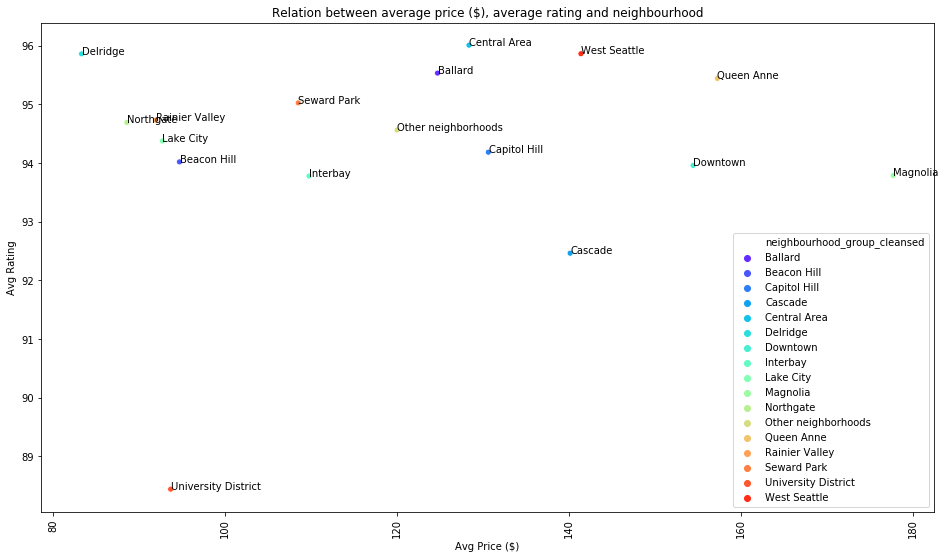

In [51]:
#Price and occupation by weekday
plt.figure(figsize=(16,9))
plt.xticks(rotation=90)
sns.scatterplot(x='price',y='review_scores_rating',hue='neighbourhood_group_cleansed',palette='rainbow',data=df_price_review_neigh)
plt.title('Relation between average price ($), average rating and neighbourhood', size=12)
plt.ylabel('Avg Rating', size=10)
plt.xlabel('Avg Price ($)', size=10)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_price_review_neigh.price, df_price_review_neigh.review_scores_rating, df_price_review_neigh.neighbourhood_group_cleansed, plt.gca()) 

In terms of price and reviews scores, we will find the best "price quality relationship" in neigbourhoods like Deldridge, Ballard or Central Area. 

## 3. Predict listing price

In the next section we will try to answer the last two questions:

**Q4: Can we use listing information to predict the housing price?**<br>
**Q5: Which variables impact the most to price?**<br>

On my first try, i one hot encoded all categorical variables, and the r score after training the lm model of the x_train dataset was 1: my model was overfitted!<br><br>
On the second try i iterate several times combining categorical variables, and finally getting this result (which you will find of this section): <br>
- Train score: 0.6658376796779399
- Test score: 0.6520683756477692 <br>

Once I got this result, and in order to check if this results could be better, I used the functions code provided in the lesson to find an optimal model. The results are better but quite similar: <br>
- Train score: 0.6954639830059268
- Test score: 0.6533408960814664 <br>



Firstly let's clean cleaning **numerical and categorical** variables.

In [52]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,150.0,1000.0,3000.0,100.0,40.0,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New 

- Numerical variables

In [53]:
#Numerical variables overview 
numerical = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'float']
numerical_list = listings_df.select_dtypes(include=numerical)
numerical_list.isna().sum()/numerical_list.shape[0]

id                                0.000000
scrape_id                         0.000000
host_id                           0.000000
host_listings_count               0.000524
host_total_listings_count         0.000524
latitude                          0.000000
longitude                         0.000000
accommodates                      0.000000
bathrooms                         0.004191
bedrooms                          0.001572
beds                              0.000262
square_feet                       0.974594
price                             0.000000
weekly_price                      0.473808
monthly_price                     0.602672
security_deposit                  0.511262
cleaning_fee                      0.269775
guests_included                   0.000000
minimum_nights                    0.000000
maximum_nights                    0.000000
availability_30                   0.000000
availability_60                   0.000000
availability_90                   0.000000
availabilit

- Unusefull data dropped: data id, latitude, longitude
- License and square_feet are dropped out since over 90% of the data is null
- if there is null value, it is filled with the mean of the column

In [54]:
droplist = ['scrape_id','host_id','latitude','longitude','license','square_feet','id']
numeric_df = numerical_list.drop(droplist,axis=1)
numeric_df = numeric_df.fillna(numeric_df.mean())

In [55]:
numeric_df.describe()

,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,7.157757,7.157757,3.349398,1.259469,1.307712,1.735394,127.976166,788.481832,2613.336190,287.610397,61.710904,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,28.620648,28.620648,1.977599,0.589130,0.882700,1.139330,90.250022,386.117854,1085.398578,188.886166,41.725079,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.020223,0.635022,0.725880,0.541745,0.517493,0.572542,0.682751,5.893029,1.665964
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,20.000000,100.000000,500.000000,95.000000,5.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,75.000000,620.000000,2603.334047,250.000000,35.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,94.000000,9.636392,9.000000,9.786709,9.809599,9.000000,9.000000,1.000000,0.830000
50%,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,788.481832,2613.336190,287.610397,61.710904,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.452245,1.000000,2.000000
75%,3.000000,3.000000,4.000000,1.000000,2.000000,2.000000,150.000000,788.481832,2613.336190,287.610397,65.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.660000
max,502.000000,502.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,6300.000000,19500.000000,5000.000000,300.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


Text(0.5, 1, 'Pair-wise correlation')

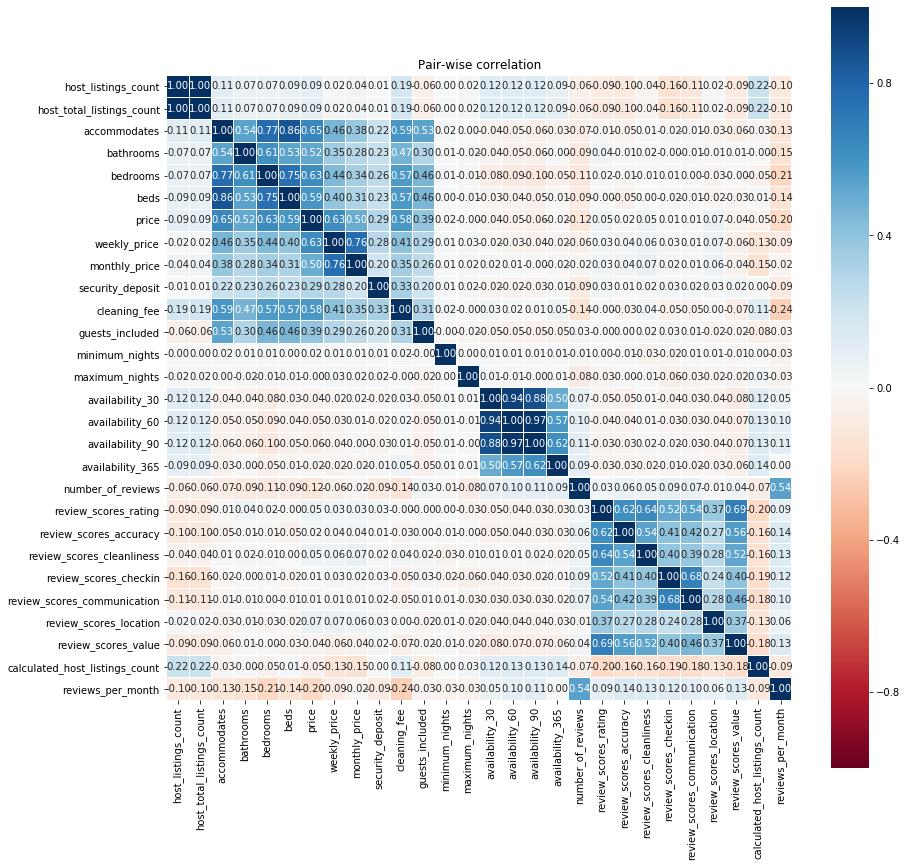

In [56]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,14))
sns.heatmap(numeric_df.corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-wise correlation')

Price is highly correlated with `accomodates`, `bathrooms`, `bedrooms`, `beds`, `cleaning_fee`, `security_deposit` and `guest_included` 

In [57]:
#Categorical variables overview 
category = ['object']
categorical_list = listings_df.select_dtypes(include=category)
categorical_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 57 columns):
listing_url                         3818 non-null object
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498 non-null object
host_url                            3818 non-null object
host_name                           38

In [58]:
#We keep location variables to see if they are a good price indicators: `neighbourhood_group_cleansed` and `zipcode`
categorical_df = categorical_list[['neighbourhood_group_cleansed','zipcode','cancellation_policy','host_is_superhost','room_type','bed_type','host_response_time','require_guest_profile_picture']]

In [59]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = categorical_df.columns

def create_dummy_df(df, cat_cols, dummy_na):
    
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

categorical_df_dummy = create_dummy_df(categorical_df, cat_cols_lst, dummy_na=False)

In [60]:
categorical_df_dummy.head()

,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,zipcode_98102,zipcode_98103,zipcode_98104,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98121,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98134,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98177,zipcode_98178,zipcode_98199,zipcode_99 98122,cancellation_policy_moderate,cancellation_policy_strict,host_is_superhost_t,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,require_guest_profile_picture_t
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [61]:
model_df = pd.concat([numeric_df, categorical_df_dummy], axis=1,sort=False)

In [62]:
model_df.head()

,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,zipcode_98102,zipcode_98103,zipcode_98104,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98121,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98134,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98177,zipcode_98178,zipcode_98199,zipcode_99 98122,cancellation_policy_moderate,cancellation_policy_strict,host_is_superhost_t,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,require_guest_profile_picture_t
0,3.0,3.0,4,1.0,1.0,1.0,85.0,788.481832,2613.33619,287.610397,61.710904,2,1,365,14,41,71,346,207,95.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,2,4.070000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
1,6.0,6.0,4,1.0,1.0,1.0,150.0,1000.000000,3000.00000,100.000000,40.000000,1,2,90,13,13,16,291,43,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6,1.480000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1
2,2.0,2.0,11,4.5,5.0,7.0,975.0,788.481832,2613.33619,1000.000000,300.000000,10,4,30,1,6,17,220,20,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2,1.150000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3,1.0,1.0,3,1.0,0.0,2.0,100.0,650.000000,2300.00000,287.610397,61.710904,1,1,1125,0,0,0,143,0,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,1,2.078919,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2.0,2.0,6,2.0,3.0,3.0,450.0,788.481832,2613.33619,700.000000,125.000000,6,1,1125,30,60,90,365,38,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1,0.890000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


### 3.1. Data Modeling

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [64]:
#Split into explanatory and response variables
X = model_df.drop(['price'], axis=1)
y = model_df['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [65]:
test_score

0.6520683756477692

In [66]:
train_score

0.6658376796779399

In [67]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
62,zipcode_98134,80.666372,80.666372
66,zipcode_98177,-59.770928,59.770928
74,room_type_Shared room,-54.510329,54.510329
61,zipcode_98133,-43.962773,43.962773
67,zipcode_98178,-39.735597,39.735597
33,neighbourhood_group_cleansed_Interbay,-36.488954,36.488954
69,zipcode_99\n98122,-34.284011,34.284011
46,zipcode_98105,-31.656710,31.656710
59,zipcode_98125,-30.838432,30.838432
54,zipcode_98117,-28.458452,28.458452


In [68]:
coef_df.shape

(83, 3)

- We can predict price with linear models. Scores are not excellent (0.65), so we could try to use another models.
- Locations (neighborhood and zip codes) are the variables which affect the most to the price of an Airbnb place.

### 3.2 Finding an optimal model

In [69]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = categorical_list.columns

def create_dummy_df(df, cat_cols, dummy_na):
    
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

categorical_df_dummy = create_dummy_df(categorical_list, cat_cols_lst, dummy_na=False)

In [70]:
model_df = pd.concat([numeric_df, categorical_df_dummy], axis=1,sort=False)

In [71]:
X = model_df.drop(['price'], axis=1)
y = model_df['price']

In [72]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

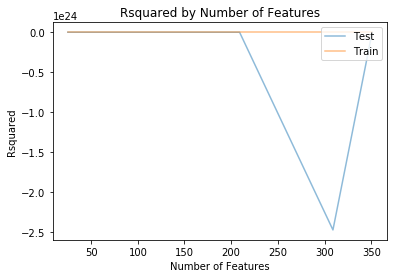

In [73]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [74]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

209
0.6533408960814664
0.6954639830059268


In [75]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
135,neighbourhood_group_cleansed_University District,-9.506959e+14,9.506959e+14
119,neighbourhood_cleansed_University District,9.506959e+14,9.506959e+14
137,city_Seattle,9.057472e+14,9.057472e+14
158,"smart_location_Seattle, WA",-9.057472e+14,9.057472e+14
121,neighbourhood_cleansed_West Queen Anne,4.660183e+14,4.660183e+14
110,neighbourhood_cleansed_Lower Queen Anne,4.660183e+14,4.660183e+14
104,neighbourhood_cleansed_East Queen Anne,4.660183e+14,4.660183e+14
115,neighbourhood_cleansed_North Queen Anne,4.660183e+14,4.660183e+14
133,neighbourhood_group_cleansed_Queen Anne,-4.660183e+14,4.660183e+14
117,neighbourhood_cleansed_Ravenna,-1.033179e+02,1.033179e+02


As we saw in the first data model, locations seem to be the variables which affect the most to price

## 4. Conclusion

* **Q1: When is the best time of the year to visit Seattle in terms of availability and pricing?**<br><br>
If you are planning for a cheap booking January and February are your months. But keep in mind that the reservation rate is higher than other months except for summer dates (July and Aug)<br><br>
* **Q2: Do prices and availability change depending the weekday?**<br><br>
Booking a place on weekends will be more expensive than labour days, taking also into account that there will also more demand<br><br>
* **Q3: Where are the best locations to book a place through Airbnb?**<br><br>
In terms of price and reviews scores, we will find the best "price quality relationship" in neigbourhoods like Deldridge, Ballard or Central Area. <br><br>
* **Q4: Can we use listing information to predict the housing price?**<br><br>
We can predict price with listing information and linear models. Scores are not excellent (0.65), so we could try to use another models.<br><br>
* **Q5: Which variables impact the most to price?**<br><br>
Locations (neighborhood and zip codes) are the variables which affect the most to the price of an Airbnb place.